In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score

In [2]:
df = pd.read_csv('Boston.csv')
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [3]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# DETECT MULTICOLLINEARITY

__USING HEATMAP__

Text(0.5, 1.0, 'Heatmap Korelasi')

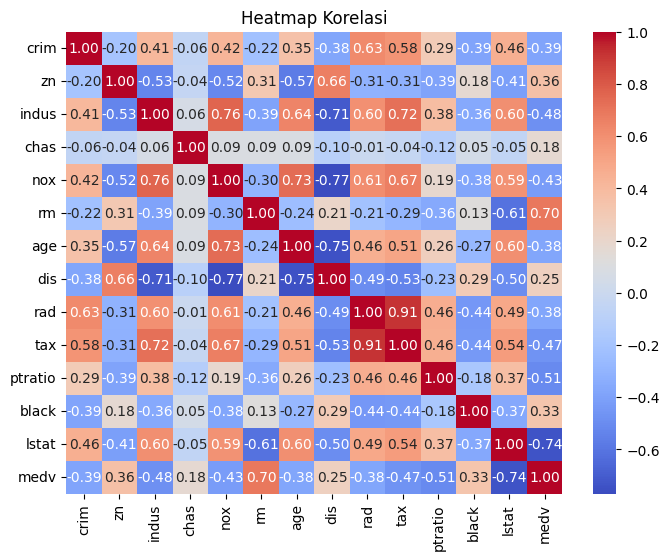

In [4]:
plt.figure(figsize=(8, 6)) 
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap Korelasi')

__SPLITTING THE DATA__

Splitting data become : train | validate | test

In [6]:
# split train test
from sklearn.model_selection import train_test_split

feature = df.drop(columns='medv')
target = df[['medv']]

# First splitting: pretrain and test
feature_df_pretrain, feature_df_test, target_df_pretrain, target_df_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# Second splitting: train and validation
feature_df_train, feature_df_validation, target_df_train, target_df_validation = train_test_split(feature_df_pretrain, target_df_pretrain, test_size=0.20, random_state=42)

Makes medv as a target for predicting house price

__Detect MULTICOLLINEARITY by computing Variance Inflation Factor (VIF)__

In [7]:
# calculate VIF scores for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_df_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


nox, dis, rad, tax have high vif score (>4)

__Drop the high correlated Feature__

dropping feature to decrease the high vif score

In [8]:
feature_df_train = feature_df_train.drop(columns=['age','rad', 'dis'])
feature_df_validation = feature_df_validation.drop(columns=['age','rad', 'dis'])
feature_df_test = feature_df_test.drop(columns=['age','rad', 'dis'])

__RE CHECKING__

In [9]:
# calculate VIF scores for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_df_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.589005
2,zn,1.807291
3,indus,3.268128
4,chas,1.096930
5,nox,3.711306
6,rm,1.749652
7,tax,3.155773
8,ptratio,1.784505
9,black,1.350174
10,lstat,2.654660


Now, the vif score looks good (<4)

## Training Ridge and Lasso Model

__Training Ridge Regression Model__

In [10]:
from sklearn.linear_model import Ridge

# train the model
X_df_train = feature_df_train.to_numpy()
y_df_train = target_df_train.to_numpy()
y_df_train = y_df_train.reshape(len(y_df_train),)

# define the model
ridge_reg = Ridge(alpha=0.1, 
                  random_state=42)

ridge_reg.fit(X_df_train, y_df_train)

Ridge(alpha=0.1, random_state=42)

__Interpreting the Obtained Model__

In [11]:
data = feature_df_train
model = ridge_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,7.218843
1,crim,-0.048435
2,zn,-0.024588
3,indus,0.098273
4,chas,3.316370
5,nox,-6.873778
6,rm,5.744822
7,tax,0.000919
8,ptratio,-0.937877
9,black,0.012959


An increase of 1 point in rm, while the other 
features are kept fixed, is associated with a 
increa 4.96656161 poinin medvob

__Training Lasso Regression Model__

In [12]:
from sklearn.linear_model import Lasso

# define the model
lasso_reg = Lasso(alpha=0.1,
                  random_state=42)

lasso_reg.fit(X_df_train, y_df_train)

Lasso(alpha=0.1, random_state=42)

__Interpreting the Obtained Model__

In [13]:
data = feature_df_train
model = lasso_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,4.865178
1,crim,-0.048545
2,zn,-0.015768
3,indus,0.060463
4,chas,1.621034
5,nox,-0.000000
6,rm,5.461967
7,tax,-0.000393
8,ptratio,-0.844463
9,black,0.013381


An increase of 1 point in rm, while the other features are kept fixed, is associated with an increase 4.844113 point in medv

## Choosing the best lambda for Ridge Regression and Lasso Regression

__Train multiple model of Ridge Regression with diffrent lambda__

In [14]:
from sklearn.linear_model import Ridge

# train the model
X_df_train = feature_df_train.to_numpy()
y_df_train = target_df_train.to_numpy()
y_df_train = y_df_train.reshape(len(y_df_train),)

# define the model
# 4 models with 4 different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_df_train, y_df_train)
ridge_reg_pointone.fit(X_df_train, y_df_train)
ridge_reg_one.fit(X_df_train, y_df_train)
ridge_reg_ten.fit(X_df_train, y_df_train)

Ridge(alpha=10, random_state=42)

__Find best model of ridge regression from validation set__

In [15]:
from sklearn.metrics import mean_squared_error

X_df_validation = feature_df_validation.to_numpy()
y_df_validation = target_df_validation.to_numpy()
y_df_validation = y_df_validation.reshape(len(y_df_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_df_validation)
    rmse = np.sqrt(mean_squared_error(y_df_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 5.098268420074665
RMSE of Ridge regression model with alpha = 0.1 is 5.095403450801558
RMSE of Ridge regression model with alpha = 1.0 is 5.080605055050947
RMSE of Ridge regression model with alpha = 10 is 5.0256882342680935


We can see that Ridge with alpha=10 has the smallest RMSE --> The best model

__Coefficient of the best lasso regression model with lambda__

Choose the smallest value based on RMSE

In [16]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_df_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,7.540114
1,crim,-0.048509
2,zn,-0.017210
3,indus,0.062253
4,chas,2.158150
5,nox,-0.690866
6,rm,5.221478
7,tax,-0.000087
8,ptratio,-0.881094
9,black,0.013078


An increase of 1 point in rm, while the other features are kept fixed, is associated with an increase 4.602393 point in medv

__Train multiple model of Lasso Regression with diffrent lambda__

In [17]:
from sklearn.linear_model import Lasso

# train the model
X_df_train = feature_df_train.to_numpy()
y_df_train = target_df_train.to_numpy()
y_df_train = y_df_train.reshape(len(y_df_train),)

# define the model
# 4 models with 4 different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_df_train, y_df_train)
lasso_reg_pointone.fit(X_df_train, y_df_train)
lasso_reg_one.fit(X_df_train, y_df_train)
lasso_reg_ten.fit(X_df_train, y_df_train)

Lasso(alpha=10, random_state=42)

__Find best model of lasso regression from validation set__

In [18]:
from sklearn.metrics import mean_squared_error

X_df_validation = feature_df_validation.to_numpy()
y_df_validation = target_df_validation.to_numpy()
y_df_validation = y_df_validation.reshape(len(y_df_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_df_validation)
    rmse = np.sqrt(mean_squared_error(y_df_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 5.085135239272938
RMSE of Lasso regression model with alpha = 0.1 is 5.059655909413482
RMSE of Lasso regression model with alpha = 1.0 is 4.8846734459521866
RMSE of Lasso regression model with alpha = 10 is 5.433081529718637


We can see that Lasso with alpha=1.0 has the smallest RMSE --> The best model

__Coefficient of the best lasso regression model with lambda__

Choose the smallest value based on RMSE

In [19]:
lasso_best = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_df_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,22.909724
1,crim,-0.028972
2,zn,-0.015200
3,indus,0.002053
4,chas,0.000000
5,nox,0.000000
6,rm,2.941434
7,tax,0.000029
8,ptratio,-0.805970
9,black,0.011680


An increase of 1 point in rm, while the other features are kept fixed, is associated with an increase 2.286992 point in medv

## Diagnostic Model

__R-Squared for ridge regression model based on smallest RMSE__

In [20]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_df_train)

print('R-squared for training data is {}'.format(r2_score(y_df_train, y_predict_train)))

R-squared for training data is 0.7276321769842198


R-squared training data is 72%! successfully explained (modelled)

__R-Squared for lasso regression model based on smallest RMSE__

In [21]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(X_df_train)

print('R-squared for training data is {}'.format(r2_score(y_df_train, y_predict_train)))

R-squared for training data is 0.6901461481238917


R-squared training data is 69%! successfully explained (modelled)

__Visualizing scatter plot to see residuals__

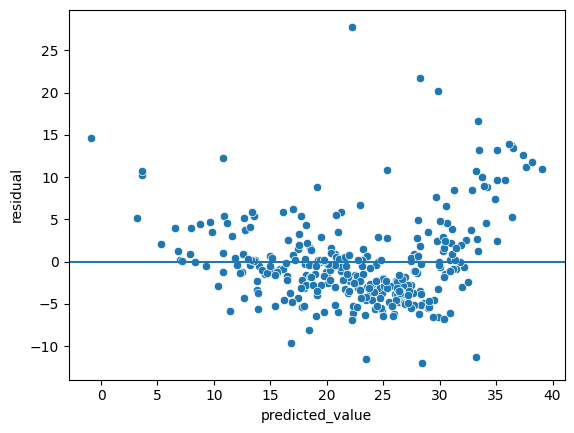

In [22]:
# calculate residuals
residual = y_df_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

## Evaluate Model Performance

__Evaluating training error for ridge regression with best lambda__

In [23]:
y_predict_train = ridge_best.predict(X_df_train)

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_df_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_df_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_df_train, y_predict_train)))

RMSE for training data is 4.973805934214741
MAE for training data is 3.5114230940990825
MAPE for training data is 0.17331678984422316


- The RMSE training error is good because RMSE value is low if we compare with target value
- MAE and MAPE are good, because its under 20%, and we can say that the model is not underfitting

__Evaluating training error for lasso regression with best lambda__

In [25]:
y_predict_train = lasso_best.predict(X_df_train)

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_df_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_df_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_df_train, y_predict_train)))

RMSE for training data is 5.305048834092741
MAE for training data is 3.7812526295995066
MAPE for training data is 0.17632038279736761


- The RMSE training error is good because RMSE value is low if we compare with the target value
- MAE and MAPE training error are good, because its under 20%, but its lil bit higher (0.00349144869289972 gap) than ridge regression training error, and we can say this model is not underfitting

__Evaluating testing error for ridge regression with best lambda__

In [27]:
# prepare prediction result on test data
X_df_test = feature_df_test.to_numpy()
y_predict_test = ridge_best.predict(X_df_test)

# ground truth target
y_df_test = target_df_test.to_numpy()
y_df_test = y_df_test.reshape(len(y_df_test),)

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_df_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_df_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_df_test, y_predict_test)))

RMSE for testing data is 5.480676526334267
MAE for testing data is 3.410717149955211
MAPE for testing data is 0.18309305709162868


- The RMSE testing error is good because RMSE value is low if we compare with target value
- MAE and MAPE are good, because its under 20%, -+ same with training training error (not overfitting), and we can say that the model Just Right

__Evaluating testing error for lasso regression with best lambda__

In [29]:
# prepare prediction result on test data
X_df_test = feature_df_test.to_numpy()
y_predict_test = lasso_best.predict(X_df_test)

# ground truth target
y_df_test = target_df_test.to_numpy()
y_df_test = y_df_test.reshape(len(y_df_test),)

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_df_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_df_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_df_test, y_predict_test)))

RMSE for testing data is 5.33956016704644
MAE for testing data is 3.572900527120015
MAPE for testing data is 0.18399301988769076


- The RMSE testing error is good because RMSE value is low if we compare with target value- 
MAE and MAPE are good, because its under 20%, -+ same with training training error (not overfitting), and we can say that the model Just Right

## TRY THE MODEL

In [35]:
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [94]:
Ani = pd.DataFrame(
    {
        'crim' : [0.03237],
        'zn' : [0.0],
        'indus' : [2.18],
        'chas' : [0],
        'nox' : [0.573],
        'rm' : [6.976],
        'tax' : [270],
        'ptratio' : [20.00],
        'black' : [392.83],
        'lstat' : [9.67]	
    }

)
Ani

,crim,zn,indus,chas,nox,rm,tax,ptratio,black,lstat
0,0.03237,0.0,2.18,0,0.573,6.976,270,20.0,392.83,9.67


In [95]:
print('Housing price predict :', ridge_best.predict(Ani))

Housing price predict : [26.31406489]
